# 資料準備

In [1]:
import time
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import data
#import dataset

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

# 設定參數

In [2]:
# Number of color channels for the images: 1 channel for gray-scale.
num_channels =3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['Brook','Clown','Gold','Soldier','White']
#classes = ['0','1','2','3','4','5','6','7','8','9']
num_classes = len(classes)

# batch size
batchSize = 100

# validation split
validation_size = .15
testdation_size = .15

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_path = 'U:/git/fish_Recognition/example/train'
test_path = 'U:/git/fish_Recognition/example/test'
checkpoint_dir = "./set_models/"

# 建立共用函數

In [3]:
#data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
#test_data = dataset.read_test_set(test_path, img_size, classes, validation_size=0)
data = data.read_train_sets(train_path, img_size, classes, validation_size=validation_size,testdation_size=testdation_size)

Reading training images
Loading Brook files (Index: 0)
Loading Clown files (Index: 1)
Loading Gold files (Index: 2)
Loading Soldier files (Index: 3)
Loading White files (Index: 4)


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
#print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))
print("-Testdation-set:\t{}".format(len(data.test.labels)))

Size of:
- Training-set:		2000
- Validation-set:	428
-Testdation-set:	428


In [5]:
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1),
                       name ='W')

In [6]:
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape)
                       , name = 'b')

In [7]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], 
                        padding='SAME')

In [8]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], 
                          strides=[1,2,2,1], 
                          padding='SAME')

# 輸入層 Input Layer

In [9]:
with tf.name_scope('Input_Layer'):
    x = tf.placeholder("float",shape=[None, img_size_flat]
                       ,name="x")    
    x_image = tf.reshape(x, [-1, img_size, img_size,num_channels])

# Convolutional Layer 1

In [10]:
with tf.name_scope('C1_Conv'):
    W1 = weight([5,5,num_channels,16])
    b1 = bias([16])
    Conv1=conv2d(x_image, W1)+ b1
    C1_Conv = tf.nn.relu(Conv1 )

In [11]:
with tf.name_scope('C1_Pool'):
    C1_Pool = max_pool_2x2(C1_Conv)

# Convolutional Layer 2

In [12]:
with tf.name_scope('C2_Conv'):
    W2 = weight([5,5,16,36])
    b2 = bias([36])
    Conv2=conv2d(C1_Pool, W2)+ b2
    C2_Conv = tf.nn.relu(Conv2)

In [13]:
with tf.name_scope('C2_Pool'):
    C2_Pool = max_pool_2x2(C2_Conv) 

# Convolutional Layer 3

In [14]:
with tf.name_scope('C3_Conv'):
    W3 = weight([5,5,36,64])
    b3 = bias([64])
    Conv3=conv2d(C2_Pool, W3)+ b3
    C3_Conv = tf.nn.relu(Conv3)

In [15]:
with tf.name_scope('C3_Pool'):
    C3_Pool = max_pool_2x2(C3_Conv) 

# Convolutional Layer 4

In [16]:
with tf.name_scope('C4_Conv'):
    W4 = weight([5,5,64,128])
    b4 = bias([128])
    Conv4=conv2d(C3_Pool, W4)+ b4
    C4_Conv = tf.nn.relu(Conv4)

In [17]:
with tf.name_scope('C4_Pool'):
    C4_Pool = max_pool_2x2(C4_Conv) 

# Fully Connected Layer

In [18]:
with tf.name_scope('D_Flat'):
    layer_shape = C4_Pool.get_shape()
    num_features = layer_shape[1:4].num_elements()
    D_Flat = tf.reshape(C4_Pool, [-1, num_features])

In [19]:
with tf.name_scope('D_Hidden_Layer'):
    W5= weight([num_features, 128])
    b5= bias([128])
    D_Hidden = tf.nn.relu(
                  tf.matmul(D_Flat, W5)+b5)
    D_Hidden_Dropout= tf.nn.dropout(D_Hidden, 
                                keep_prob=0.7)

# 輸出層Output

In [20]:
with tf.name_scope('Output_Layer'):
    W6 = weight([128,num_classes])
    b6 = bias([num_classes])
    y_predict= tf.nn.softmax(
                 tf.matmul(D_Hidden_Dropout,
                           W6)+b6)

# 設定訓練模型最佳化步驟

In [21]:
with tf.name_scope("optimizer"):
    
    y_label = tf.placeholder("float", shape=[None, num_classes], 
                              name="y_label")
    
    loss_function = tf.reduce_mean(
                      tf.nn.softmax_cross_entropy_with_logits
                         (logits=y_predict , 
                          labels=y_label))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.00001) \
                    .minimize(loss_function)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# 設定評估模型

In [22]:
with tf.name_scope("evaluate_model"):
    correct_prediction = tf.equal(tf.argmax(y_predict, 1),
                                  tf.argmax(y_label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) # 非零為一，的平均差

# 訓練模型

In [23]:
trainEpochs = 500
train_batch_size = batchSize
valid_batch_size =  428
totalBatchs = int(len(data.train.labels)/batchSize)
epoch_list=[];accuracy_list=[];loss_list=[];
from time import time
startTime=time()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [24]:
for epoch in range(trainEpochs):

    
    for i in range(totalBatchs):
        #batch_x, batch_y = mnist.train.next_batch(batchSize)
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        
        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]
        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        
        #sess.run(optimizer,feed_dict={x: batch_x, y_label: batch_y})
        sess.run(optimizer,feed_dict={x: x_batch, y_label: y_true_batch})
    x_valid_batch, y_vtrue_batch, _, valid_cls_batch = data.valid.next_batch(valid_batch_size)
    x_valid_batch = x_valid_batch.reshape(valid_batch_size, img_size_flat)
    loss,acc = sess.run([loss_function,accuracy],
                        feed_dict={x: x_valid_batch, 
                                   y_label: y_vtrue_batch})

    epoch_list.append(epoch)
    loss_list.append(loss);accuracy_list.append(acc)    
    
    print("Train Epoch:", '%02d' % (epoch+1), \
          "Loss=","{:.9f}".format(loss)," Accuracy=",acc)
    
duration =time()-startTime
print("Train Finished takes:",duration)         

Train Epoch: 01 Loss= 1.715389729  Accuracy= 0.18457943
Train Epoch: 02 Loss= 1.724534631  Accuracy= 0.17289719
Train Epoch: 03 Loss= 1.701235652  Accuracy= 0.19158879
Train Epoch: 04 Loss= 1.706140280  Accuracy= 0.18925233
Train Epoch: 05 Loss= 1.698140979  Accuracy= 0.20093457
Train Epoch: 06 Loss= 1.672611237  Accuracy= 0.22663552
Train Epoch: 07 Loss= 1.682952881  Accuracy= 0.20794393
Train Epoch: 08 Loss= 1.654356241  Accuracy= 0.2406542


KeyboardInterrupt: 

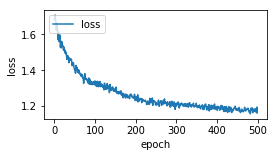

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list, loss_list, label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')

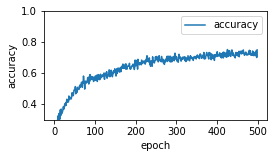

In [26]:
plt.plot(epoch_list, accuracy_list,label="accuracy" )
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.ylim(0.3,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


# 評估模型準確率

In [50]:
len(data.test.labels)

428

In [51]:
test_size = 428
x_test_batch, y_test_batch, _, test_cls_batch = data.test.next_batch(test_size)
x_test_batch = x_test_batch.reshape(test_size, img_size_flat)
print("Accuracy:", 
      sess.run(accuracy,feed_dict={x: x_test_batch,
                                   y_label: y_test_batch}))

Accuracy: 0.69859815


In [52]:
print("Accuracy:", 
      sess.run(accuracy,feed_dict={x: x_test_batch[:200],
                                   y_label: y_test_batch[:200]}))


Accuracy: 0.735


In [53]:
print("Accuracy:", 
      sess.run(accuracy,feed_dict={x:x_test_batch[200:],
                                   y_label: y_test_batch[200:]}))

Accuracy: 0.6403509


# 預測機率

In [54]:
y_predict=sess.run(y_predict, 
                   feed_dict={x: x_test_batch[:10]})

TypeError: Fetch argument array([[2.6714618e-04, 8.4278006e-05, 7.6833689e-03, 9.9182057e-01,
        1.4462149e-04],
       [9.9901915e-01, 2.9641905e-04, 2.8954700e-04, 3.9483624e-04,
        1.3950986e-07],
       [1.0000000e+00, 3.6541354e-09, 1.0431640e-09, 2.5237423e-08,
        1.9106636e-09],
       ...,
       [7.2952336e-01, 1.2575011e-01, 2.7079958e-02, 1.0038595e-01,
        1.7260654e-02],
       [6.5077329e-01, 6.4338602e-02, 4.0160536e-04, 3.2641698e-02,
        2.5184482e-01],
       [4.5172455e-10, 3.7921831e-07, 9.9999964e-01, 4.3319326e-09,
        4.5140565e-11]], dtype=float32) has invalid type <class 'numpy.ndarray'>, must be a string or Tensor. (Can not convert a ndarray into a Tensor or Operation.)

In [55]:
y_predict[:5]

array([[2.6714618e-04, 8.4278006e-05, 7.6833689e-03, 9.9182057e-01,
        1.4462149e-04],
       [9.9901915e-01, 2.9641905e-04, 2.8954700e-04, 3.9483624e-04,
        1.3950986e-07],
       [1.0000000e+00, 3.6541354e-09, 1.0431640e-09, 2.5237423e-08,
        1.9106636e-09],
       [2.9820576e-06, 1.4432645e-02, 6.9787777e-05, 4.2324373e-03,
        9.8126215e-01],
       [6.1181438e-10, 2.2507365e-05, 9.9997699e-01, 5.0141927e-07,
        4.4491727e-14]], dtype=float32)

# 預測結果

In [56]:
prediction_result=sess.run(tf.argmax(y_predict,1),
                           feed_dict={x:x_test_batch[:400] ,
                                      y_label:y_test_batch[:400]})

In [57]:
prediction_result[:20]


array([3, 0, 0, 4, 2, 1, 1, 2, 4, 2, 4, 0, 2, 2, 0, 0, 0, 0, 1, 0],
      dtype=int64)

In [58]:
y_test_batch[:10]

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]])

In [59]:
import numpy as np
def show_images_labels_predict(images,labels,prediction_result):
    fig = plt.gcf()
    fig.set_size_inches(8, 10)
    for i in range(0, 10):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(np.reshape(images[i],(img_size, img_size,num_channels)), 
                  cmap='binary')
        ax.set_title("label=" +str(np.argmax(labels[i]))+
                     ",predict="+str(prediction_result[i])
                     ,fontsize=9) 
    plt.show()

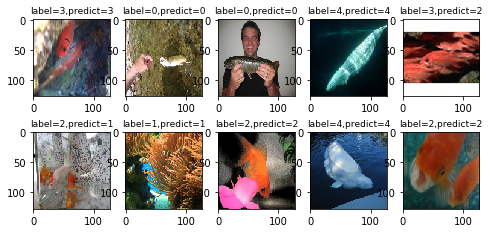

In [60]:
show_images_labels_predict(data.test.images,data.test.labels,prediction_result)

# 找出預測錯誤

In [61]:
for i in range(400):
    if prediction_result[i]!=np.argmax(data.test.labels[i]):
        print("i="+str(i)+
              "   label=",np.argmax(data.test.labels[i]),
              "predict=",prediction_result[i])

i=4   label= 3 predict= 2
i=5   label= 2 predict= 1
i=16   label= 2 predict= 0
i=17   label= 2 predict= 0
i=21   label= 3 predict= 0
i=22   label= 3 predict= 0
i=24   label= 1 predict= 4
i=25   label= 4 predict= 2
i=32   label= 1 predict= 0
i=34   label= 2 predict= 3
i=35   label= 3 predict= 4
i=36   label= 3 predict= 2
i=37   label= 1 predict= 2
i=38   label= 4 predict= 1
i=42   label= 3 predict= 4
i=58   label= 2 predict= 1
i=60   label= 1 predict= 0
i=61   label= 2 predict= 3
i=63   label= 1 predict= 2
i=66   label= 0 predict= 3
i=72   label= 3 predict= 4
i=74   label= 2 predict= 0
i=79   label= 2 predict= 4
i=81   label= 2 predict= 3
i=84   label= 3 predict= 0
i=88   label= 0 predict= 1
i=89   label= 2 predict= 4
i=90   label= 0 predict= 4
i=91   label= 2 predict= 1
i=92   label= 1 predict= 2
i=93   label= 4 predict= 3
i=100   label= 2 predict= 3
i=101   label= 4 predict= 1
i=102   label= 3 predict= 4
i=103   label= 0 predict= 3
i=104   label= 3 predict= 1
i=105   label= 3 predict=

In [62]:
def show_images_labels_predict_error(images,labels,prediction_result):
    fig = plt.gcf()
    fig.set_size_inches(8, 10)
    i=0;j=0
    while i<10:
        if prediction_result[j]!=np.argmax(labels[j]):
            ax=plt.subplot(5,5, 1+i)
            ax.imshow(np.reshape(images[j],(img_size, img_size,num_channels)), 
                      cmap='binary')
            ax.set_title("j="+str(j)+
                         ",l=" +str(np.argmax(labels[j]))+
                         ",p="+str(prediction_result[j])
                         ,fontsize=9) 
            i=i+1  
        j=j+1
    plt.show()

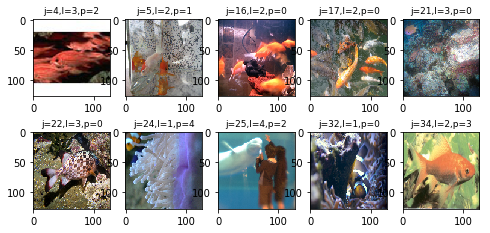

In [63]:
show_images_labels_predict_error(data.test.images,data.test.labels,prediction_result)

In [64]:
saver = tf.train.Saver()

In [65]:
save_path = saver.save(sess, "set_model/CNN")

In [66]:
print("Model saved in file: %s" % save_path)

Model saved in file: set_model/CNN


In [67]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('log/CNN',sess.graph)

In [68]:
#sess.close()